In [40]:
import numpy as np
import pandas as pd
import ssl
from bs4 import BeautifulSoup
import requests
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

In [11]:
DATA_IN_PATH = './naver_sentiment_movie_corpus/'
for file in os.listdir(DATA_IN_PATH):
    if 'txt' in file:
        print(file.ljust(30) + str(round(os.path.getsize(DATA_IN_PATH + file)/1000000,2))+'MB')

ratings.txt                   19.52MB
ratings_test.txt              4.89MB
ratings_train.txt             14.63MB


In [12]:
train_data = pd.read_csv(DATA_IN_PATH + 'ratings_train.txt',header=0, delimiter='\t',quoting=3)
train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [13]:
train_length = train_data['document'].astype(str).apply(len)
train_length

0         19
1         33
2         17
3         29
4         61
          ..
149995    19
149996    13
149997    31
149998    27
149999    24
Name: document, Length: 150000, dtype: int64

C:\Users\zoey.j.han\Anaconda3\envs\study_nlp\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  


Text(0, 0.5, 'Number of review')

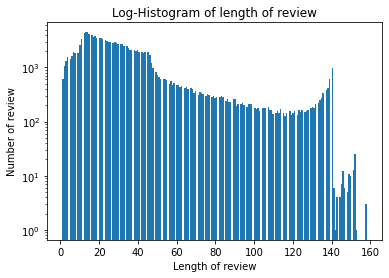

In [16]:
plt.hist(train_length, bins=200, label='word')
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of length of review')
plt.xlabel('Length of review')
plt.ylabel('Number of review')

In [19]:
print('리뷰 길이 최댓값: {}'.format(np.max(train_length)))
print('리뷰 길이 최솟값: {}'.format(np.min(train_length)))
print('리뷰 길이 평균값: {}'.format(np.mean(train_length)))
print('리뷰 길이 표준편차: {}'.format(np.std(train_length)))
print('리뷰 길이 중간값: {}'.format(np.median(train_length)))
print('리뷰 길이 제1사분위: {}'.format(np.percentile(train_length,25)))
print('리뷰 길이 제3사분위: {}'.format(np.percentile(train_length,75)))

리뷰 길이 최댓값: 158
리뷰 길이 최솟값: 1
리뷰 길이 평균값: 35.23749333333333
리뷰 길이 표준편차: 29.582262651516178
리뷰 길이 중간값: 27.0
리뷰 길이 제1사분위: 16.0
리뷰 길이 제3사분위: 42.0


In [21]:
train_data['label'].value_counts()

0    75173
1    74827
Name: label, dtype: int64

In [58]:
import numpy as np
import pandas as pd
import re
import json
from konlpy.tag import Okt
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer

DATA_IN_PATH='./naver_sentiment_movie_corpus/'
train_data = pd.read_csv(DATA_IN_PATH + 'ratings_train.txt', header=0, delimiter='\t',quoting=3)

In [59]:
train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [30]:
review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]","",train_data['document'][0])
review_text

'아 더빙 진짜 짜증나네요 목소리'

In [38]:
train_data['document'] = train_data['document'].str.replace("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]","",regex=True)
train_data['document']

0                                         아 더빙 진짜 짜증나네요 목소리
1                                흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                                 교도소 이야기구먼 솔직히 재미는 없다평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...
                                ...                        
149995                                      인간이 문제지 소는 뭔죄인가
149996                                           평점이 너무 낮아서
149997                        이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다
149998                           청춘 영화의 최고봉방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 150000, dtype: object

In [39]:
okt = Okt()
review_text = okt.morphs(review_text, stem = True)
review_text

['아', '더빙', '진짜', '짜증나다', '목소리']

In [60]:
url = "https://www.ranks.nl/stopwords/korean"
resp = requests.get(url, verify=False)
soup = BeautifulSoup(resp.text, 'lxml')
rows = soup.select('td')

bad_word_list = []
bad_word = ''
for row in rows:
    try:
        bad_word_list += (re.compile('[가-힣]+').findall(str(row)))
       
    except AttributeError as err:
        pass
print(len(bad_word_list))

C:\Users\zoey.j.han\Anaconda3\envs\study_nlp\lib\site-packages\urllib3\connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.ranks.nl'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


789


In [64]:
def preprocessing(review, okt, remove_stopwords=False, stop_words=[]):
    review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]","",review)
    word_review = okt.morphs(review_text, stem=True)
    if remove_stopwords:
        word_review = [token for token in word_review if not token in stop_words]
    return word_review

In [62]:
stop_words = list(set(bad_word_list))
len(stop_words)

618

In [66]:
train_data['document']

0                                       아 더빙.. 진짜 짜증나네요 목소리
1                         흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                             교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
                                ...                        
149995                                  인간이 문제지.. 소는 뭔죄인가..
149996                                        평점이 너무 낮아서...
149997                      이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?
149998                          청춘 영화의 최고봉.방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 150000, dtype: object

In [70]:
stop_words = list(set(bad_word_list))
okt = Okt()
clean_train_review = []
for review in train_data['document']:
    if type(review)==str:
        clean_train_review.append(preprocessing(review,okt,True,stop_words=stop_words))
    else:
        clean_train_review.append([])
        
clean_train_review

[['더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '오버', '연기', '가볍다'],
 ['무재', '밓었', '다그', '래서', '보다', '추천', '다'],
 ['교도소', '이야기', '구먼', '솔직하다', '재미', '는', '평점', '조정'],
 ['사이',
  '몬페',
  '익살스럽다',
  '연기',
  '돋보이다',
  '영화',
  '스파이더맨',
  '늙다',
  '보이다',
  '커스틴',
  '던스트',
  '너무나도',
  '이쁘다',
  '보이다'],
 ['막',
  '걸음',
  '마',
  '떼다',
  '세',
  '초등학교',
  '학년',
  '생인',
  '살다',
  '영화',
  'ㅋㅋㅋ',
  '별',
  '반개',
  '도',
  '아깝다',
  '움'],
 ['원작', '긴장감', '제대로', '살리다'],
 ['별',
  '반개',
  '도',
  '아깝다',
  '욕',
  '나오다',
  '이응경',
  '길용우',
  '연',
  '기',
  '생활',
  '인지',
  '정말',
  '발',
  '그것',
  '보단',
  '납치',
  '감금',
  '반복',
  '반복',
  '드라마',
  '는',
  '가족',
  '도',
  '연기',
  '못',
  '사람',
  '엿'],
 ['액션', '재미', '안되다', '영화'],
 ['왜케', '평점', '낮다', '꽤', '볼', '데', '헐리우드', '식', '화려하다', '너무', '길들이다'],
 ['걍', '인피니트', '짱', '이다', '진짜', '짱', '이다'],
 ['볼때',
  '마다',
  '눈물나다',
  '죽다',
  '년대',
  '향수',
  '극',
  '허진호',
  '는',
  '감성',
  '절제',
  '멜로',
  '달인',
  '이다'],
 ['울면',
  '서',
  '손',
  '고',
  '횡단보도',
  '건너다',
  '뛰다',
  

In [71]:
test_data = pd.read_csv(DATA_IN_PATH + 'ratings_test.txt',header=0, delimiter='\t',quoting=3)
clean_test_review = []
for review in test_data['document']:
    if type(review) == str:
        clean_test_review.append(preprocessing(review, okt, remove_stopwords=True,stop_words=stop_words))
    else:
        clean_test_review.append([])

In [74]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(clean_train_review)
train_sequences = tokenizer.texts_to_sequences(clean_train_review)
test_sequences = tokenizer.texts_to_sequences(clean_test_review)

word_vocab = tokenizer.word_index # word dict 

MAX_SEQUENCE_LENGTH = 8

train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')
train_labels = np.array(train_data['label'])
test_inputs = pad_sequences(test_sequences, maxlen = MAX_SEQUENCE_LENGTH,padding='post')
test_labels = np.array(test_data['label'])

In [88]:

train_inputs

array([[  394,    13,   212, ...,     0,     0,     0],
       [  807,   396,    28, ...,  1322,    17,   579],
       [ 2288, 24762,  2159, ...,   180,     9,     0],
       ...,
       [    5,  5406, 14400, ..., 10181,     5,   930],
       [  926,     1,  2107, ...,   468,  7643,     0],
       [  159,     1,  1655, ...,  1160,     1,     0]])

In [89]:
train_labels

array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

In [85]:
DATA_IN_PATH='./naver_sentiment_movie_corpus/'
TRAIN_INPUT_DATA = 'nsmc_train_input.npy'
TRAIN_LABEL_DATA = 'nsmc_train_label.npy'
TEST_INPUT_DATA = 'nsmc_test_input.npy'
TEST_LABEL_DATA = 'nsmc_test_label.npy'
DATA_CONFIGS = 'data_configs.json'

data_configs = {}

data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab)+1

if not os.path.exists(DATA_IN_PATH):
    os.makedirs(DATA_IN_PATH)
    
np.save(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'wb'),train_inputs)
np.save(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'wb'),train_labels)
np.save(open(DATA_IN_PATH + TEST_INPUT_DATA, 'wb'),test_inputs)
np.save(open(DATA_IN_PATH + TEST_LABEL_DATA, 'wb'),test_labels)

json.dump(data_configs, open(DATA_IN_PATH + DATA_CONFIGS,'w'),ensure_ascii=False)